In [1]:
import yaml
import sys
sys.path.append("../")
from plugins.interfaces.diagnostics import AWAFrameGrabberDiagnostic, ROI

# define screen and trim parameters
screen = "DYG5"
magnet_info = yaml.safe_load(open("awa_config/awa_drive_magnet_config.yml"))
screen_info = yaml.safe_load(open("awa_config/awa_drive_camera_config.yml"))[screen]

In [2]:
# create Xopt objects
from xopt import VOCS
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
        }

vocs = VOCS(
    variables = {magnet_info[name]["PV"]:magnet_info[name]["RANGE"] for name in ["DT8H","DQ4"]
    },
    observables = ["center_dist","Cx","Cy"],
    constraints=IMAGE_CONSTRAINTS
)

In [3]:
vocs

VOCS(variables={'AWA:Drive:DT8H_B_S:Ctrl': [-2.0, 2.0], 'AWA:Bira3Ctrl:Ch03': [-1.0, 1.0]}, constraints={'bb_penalty': ['LESS_THAN', 0.0]}, objectives={}, constants={}, observables=['center_dist', 'Cx', 'Cy'])

In [2]:
screen_roi = ROI(
    xcenter=int(screen_info["center"][0]),
    ycenter=int(screen_info["center"][1]),
    xwidth=int(screen_info["radius"]*1.5),
    ywidth=int(screen_info["radius"]*1.5),
)

image_diagnostic = AWAFrameGrabberDiagnostic(
    roi=screen_roi, apply_bounding_box_constraint=False, visualize=False
)

In [7]:
image_diagnostic.threshold = 200

displaying image
fitting image


{'Cx': nan,
 'Cy': nan,
 'Sx': nan,
 'Sy': nan,
 'bb_penalty': nan,
 'total_intensity': 32598.0,
 'log10_total_intensity': 4.513190955417365}

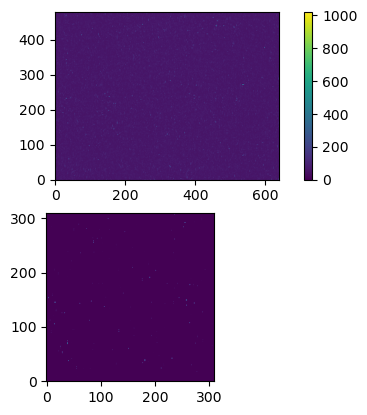

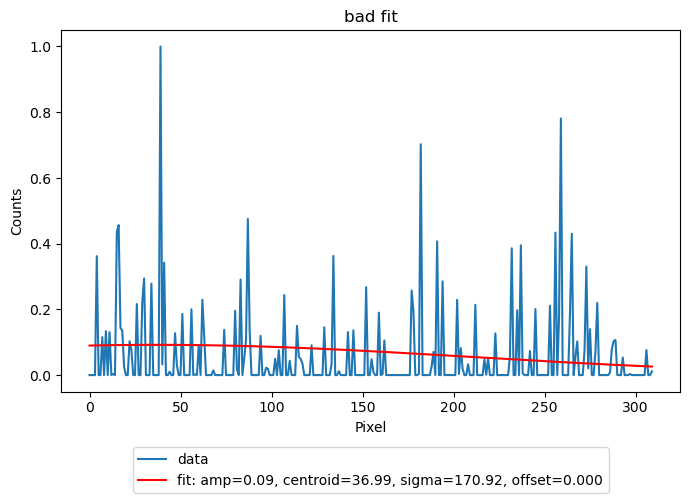

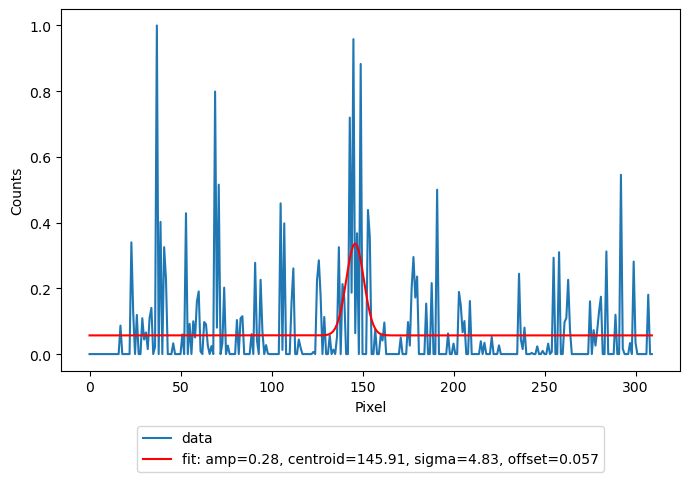

In [8]:
image_diagnostic.test_measurement()

In [6]:
import time
from xopt import Evaluator
from epics import caput

def evaluate(inputs: dict):
    global image_diagnostic
    # caput values
    for name, val in inputs.items():
        caput(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(1.0)

    results = image_diagnostic.measure_beamsize(1, **inputs)

    # measure distance to image center
    print(results["Cx"], image_diagnostic.roi.xwidth/2)
    results["center_dist_x"] = results["Cx"] - image_diagnostic.roi.xwidth/2
    results["center_dist_y"] = results["Cy"] - image_diagnostic.roi.ywidth/2

    results["center_dist"] = (results["center_dist_x"]**2 + results["center_dist_y"]**2)**0.5
    results["time"] = time.time()
    
    return results

evaluator = Evaluator(function=evaluate)

In [7]:
from xopt.generators import get_generator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

model_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = get_generator("bayesian_exploration")(
    vocs=vocs, gp_constructor=model_constructor, 
    n_interpolate_points=5, 
)
generator.numerical_optimizer.max_time = 10.0

In [8]:
from xopt import Xopt
dump_filename = "quad_misalignment_DT7_good.yml"
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator, dump_file=dump_filename)

In [9]:
X


            Xopt
________________________________
Version: 2.2.1+8.g7a7eff90.dirty
Data size: 0
Config as YAML:
dump_file: quad_misalignment_DT7_good.yml
evaluator:
  function: __main__.evaluate
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: false
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: 5
  n_monte_carlo_samples: 128
  name: bayesian_exploration
  numerical_optimizer:
    max_iter: 2000
    max_time: 10.0
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints:
    bb_penalty:
    - LESS_THAN
    - 0

In [10]:
from epics import caget_many
from xopt.utils import get_local_region
import pandas as pd
import numpy as np
current_value = dict(zip(X.vocs.variable_names, caget_many(X.vocs.variable_names)))
print(current_value)
# get small region around current point to sample
random_sample_region = get_local_region(current_value,X.vocs, fraction=0.5)

# create a mesh
xx = np.meshgrid(
    np.linspace(-0.66,0,5),
    np.linspace(-1.1,1.1,5)
)
pts = np.vstack([ele.flatten() for ele in xx])

X.evaluate_data({"AWA:Bira3Ctrl:Ch03":pts[0],"AWA:Drive:DT8H_B_S:Ctrl":pts[1]})


#X.random_evaluate(4, custom_bounds=random_sample_region)

{'AWA:Bira3Ctrl:Ch03': 0.0, 'AWA:Drive:DT8H_B_S:Ctrl': 0.0}
fitting image
74.47348379654075 155.0
fitting image
65.64028084229722 155.0
fitting image
nan 155.0
fitting image
46.17970198753466 155.0
fitting image
34.446642325228915 155.0
fitting image
99.83093123520086 155.0
fitting image
109.59352758362398 155.0
fitting image
104.9878707068844 155.0
fitting image
101.37939512637904 155.0
fitting image
96.20690341481546 155.0
fitting image
154.76242749732907 155.0
fitting image
153.61521945424886 155.0
fitting image
153.90038463753982 155.0
fitting image
154.99346367697984 155.0
fitting image
154.5180208119513 155.0
fitting image
194.03852929495244 155.0
fitting image
198.7629310825862 155.0
fitting image
203.63903510465167 155.0
fitting image
208.75130797839003 155.0
fitting image
213.8135489203612 155.0
fitting image
233.59860141453018 155.0
fitting image
243.551415166028 155.0
fitting image
253.1646800174531 155.0
fitting image
263.80896365825737 155.0
fitting image
273.7497401635851

,AWA:Bira3Ctrl:Ch03,AWA:Drive:DT8H_B_S:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
0,-0.660,-1.10,74.473484,126.586575,4.606494,31.654627,7.496143,6615129.0,6.820538,-80.526516,-28.413425,85.392286,1.710428e+09,2.374873,False
1,-0.495,-1.10,65.640281,135.460740,5.026226,27.330087,0.834541,6557401.0,6.816732,-89.359719,-19.539260,91.470990,1.710428e+09,2.348022,False
2,-0.330,-1.10,NaN,NaN,NaN,NaN,NaN,6604192.0,6.819820,NaN,NaN,NaN,1.710428e+09,2.281481,False
3,-0.165,-1.10,46.179702,146.009297,8.897789,19.050493,6.442663,6674140.0,6.824395,-108.820298,-8.990703,109.191071,1.710428e+09,2.353734,False
4,0.000,-1.10,34.446642,156.233260,12.742328,14.782403,16.505096,6712022.0,6.826853,-120.553358,1.233260,120.559666,1.710428e+09,2.397749,False
5,-0.660,-0.55,99.830931,149.442946,8.686940,20.235028,-39.027359,6782377.0,6.831382,-55.169069,-5.557054,55.448237,1.710428e+09,2.445665,False
6,-0.495,-0.55,109.593528,135.996593,4.803176,35.404173,-15.467556,6737847.0,6.828521,-45.406472,-19.003407,49.222731,1.710428e+09,2.443517,False
7,-0.330,-0.55,104.987871,140.672099,6.838372,24.897405,-33.205970,6711728.0,6.826834,-50.012129,-14.327901,52.024051,1.710428e+09,2.381351,False
8,-0.165,-0.55,101.379395,144.694371,10.685414,22.246884,-29.024789,6797737.0,6.832364,-53.620605,-10.305629,54.601971,1.710428e+09,2.317450,False
9,0.000,-0.55,96.206903,152.051093,10.644082,12.186416,-45.663675,6648916.0,6.822751,-58.793097,-2.948907,58.867005,1.710428e+09,2.354244,False


In [11]:
X.generator.train_model()

ModelListGP(
  (models): ModuleList(
    (0-3): 4 x SingleTaskGP(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
        (base_kernel): MaternKernel(
          (lengthscale_prior): GammaPrior()
          (raw_lengthscale_constraint): Positive()
        )
        (outputscale_prior): GammaPrior()
        (raw_outputscale_constraint): Positive()
      )
      (outcome_transform): Standardize()
      (input_transform): Normalize()
    )
  )
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-3): 4 x GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
    )
  )
)

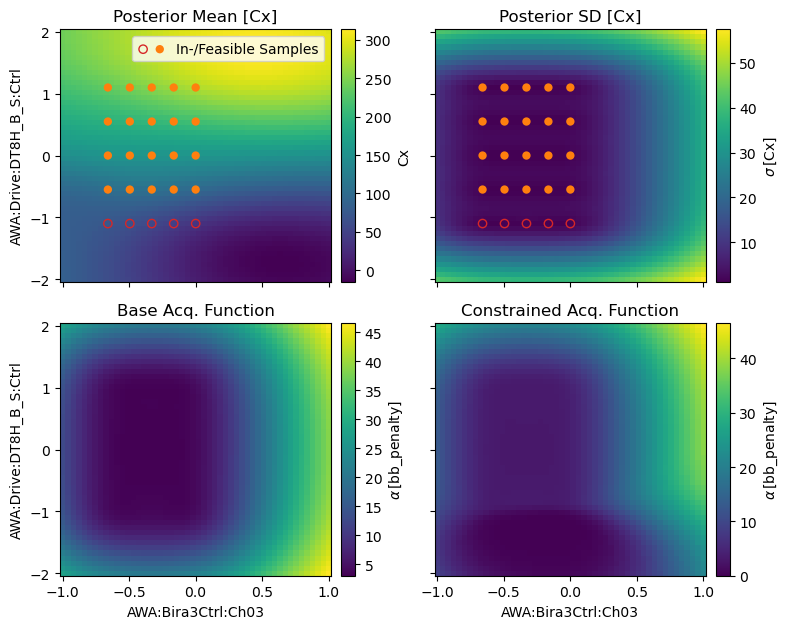

In [12]:
from xopt.generators.bayesian.visualize import visualize_generator_model
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)

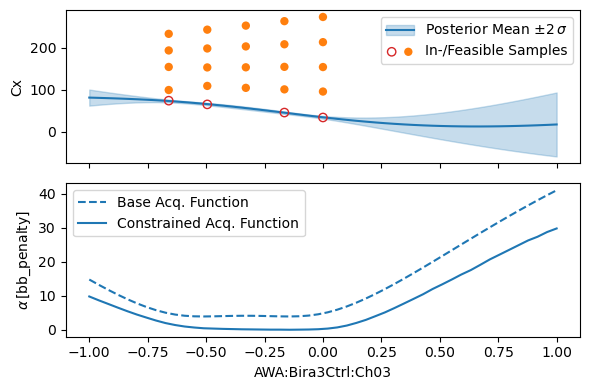

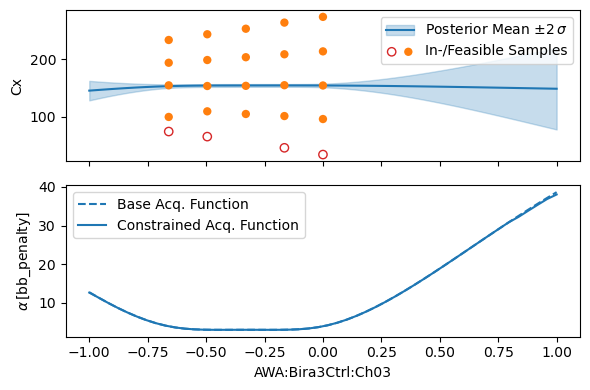

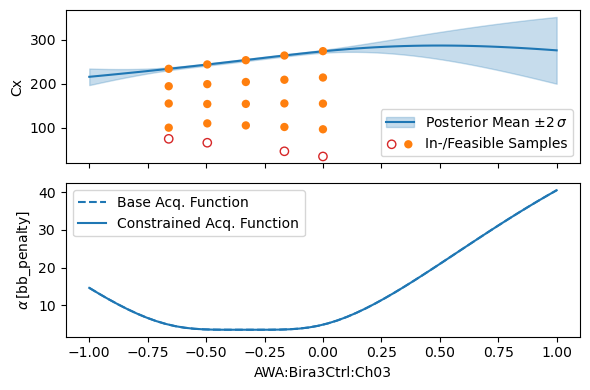

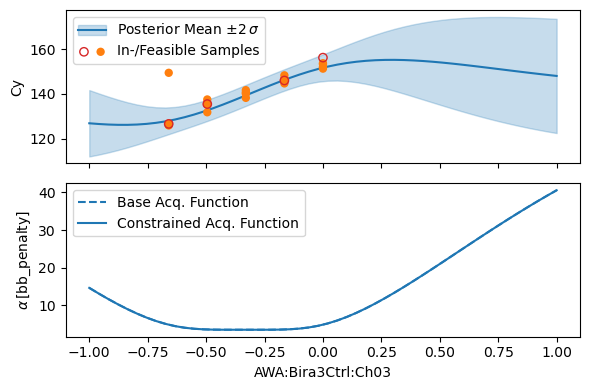

In [13]:
from xopt.generators.bayesian.visualize import visualize_generator_model

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":-1.1},
    output_names=["Cx"]
)

fig2,ax2 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":0.0},
    output_names=["Cx"]
)

fig3,ax3 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.1},
    output_names=["Cx"]
)

fig4,ax4 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.1},
    output_names=["Cy"]
)
